In [1]:
import keras

from keras.datasets import fashion_mnist

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras import backend as K


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

Using TensorFlow backend.
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
batch_size = 256     # 64, 256?

num_classes = 10

epochs = 15         # due to large amount of execution time

# input image dimensions:

img_rows, img_cols = 32, 28

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [4]:
x_train[0]
y_train[0]

9

In [5]:
#x_train=x_train.flatten()

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
x_train.reshape(60000,784)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
x_test=x_test.reshape(10000,784)
x_test.shape
x_train=x_train.reshape(60000,784)
x_train.shape

(60000, 784)

In [9]:
x_train[0]
y_train[0]

9

In [10]:
labels = { 0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', \
           5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag' , 9: 'Ankle boot'}

In [11]:

train_df=pd.DataFrame(x_train)
#train_df.head()
test_df=pd.DataFrame(x_test)
#train_df.tail()

In [12]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [13]:
df_train = spark.read.format("com.databricks.spark.csv").option("header","true").load("train.csv")
df_train=df_train.drop('_c0')

In [14]:
for i in range(0,784):
    y=str(i)
    df_train=df_train.withColumn(y, df_train[y].cast('int'))


In [15]:
from pyspark.ml.feature import VectorAssembler

In [16]:
cols_train = list(set(df_train.columns))
assembler_train = VectorAssembler(
    inputCols=cols_train,
    outputCol="vector")

In [17]:
output_train = assembler_train.transform(df_train)

In [18]:
from pyspark.ml.clustering import KMeans

In [19]:
%%time
kmeans = KMeans(k=10, featuresCol="vector",predictionCol="cluster")
model = kmeans.fit(output_train)
model_train = model.transform(output_train)


CPU times: user 24.4 ms, sys: 6.95 ms, total: 31.3 ms
Wall time: 52.1 s


In [20]:
model_train.createOrReplaceTempView("adding_train")

In [21]:
model_train = spark.sql("select *, CASE WHEN cluster=0 THEN cluster+25 WHEN cluster=1 THEN cluster+50 WHEN cluster=2 THEN cluster+75 WHEN cluster=3 THEN cluster+100 WHEN cluster=4 THEN cluster+125 WHEN cluster=5 THEN cluster+150 WHEN cluster=6 THEN cluster+175 WHEN cluster=7 THEN cluster+200 WHEN cluster=8 THEN cluster+225 WHEN cluster=9 THEN cluster+250 END cluster_1 from adding_train ")

In [22]:
model_train = model_train.drop("cluster")

In [23]:
for i in range(785,896):
    i=str(i)
    model_train=model_train.withColumn(i, model_train["cluster_1"])
model_train.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- 1: integer (nullable = true)
 |-- 2: integer (nullable = true)
 |-- 3: integer (nullable = true)
 |-- 4: integer (nullable = true)
 |-- 5: integer (nullable = true)
 |-- 6: integer (nullable = true)
 |-- 7: integer (nullable = true)
 |-- 8: integer (nullable = true)
 |-- 9: integer (nullable = true)
 |-- 10: integer (nullable = true)
 |-- 11: integer (nullable = true)
 |-- 12: integer (nullable = true)
 |-- 13: integer (nullable = true)
 |-- 14: integer (nullable = true)
 |-- 15: integer (nullable = true)
 |-- 16: integer (nullable = true)
 |-- 17: integer (nullable = true)
 |-- 18: integer (nullable = true)
 |-- 19: integer (nullable = true)
 |-- 20: integer (nullable = true)
 |-- 21: integer (nullable = true)
 |-- 22: integer (nullable = true)
 |-- 23: integer (nullable = true)
 |-- 24: integer (nullable = true)
 |-- 25: integer (nullable = true)
 |-- 26: integer (nullable = true)
 |-- 27: integer (nullable = true)
 |-- 28: integer (nullabl

In [24]:
model_train=model_train.drop("vector")

In [25]:
model_train = model_train.toPandas()

In [26]:
model_train.to_csv("train2.csv")

In [27]:
model_train = model_train.values

In [28]:
model_train.shape

(60000, 896)

In [29]:
model_train1 = model_train.reshape(60000,32,28)

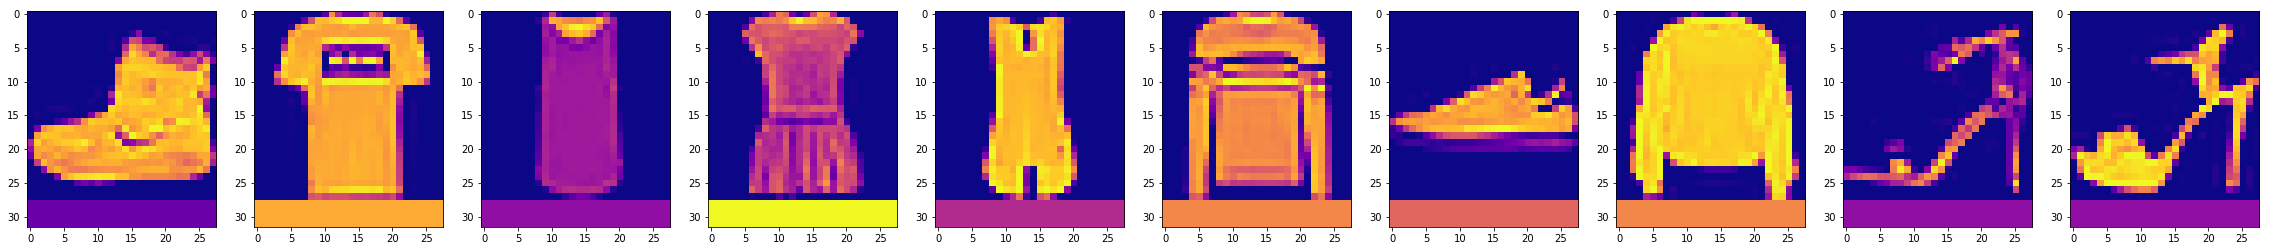

In [30]:
def display_image(data, nrows, ncols, index):
    plt.subplot(nrows, ncols, index)    
    plt.imshow(data, cmap='plasma')
ncols = 10
plt.figure(figsize=(40,40))
for i in range(ncols):
    display_image(model_train1[i], 1, ncols, i+1)            

In [31]:
df_test=spark.read.format("com.databricks.spark.csv").option("header","true").load("test.csv")
df_test=df_test.drop('_c0')

In [32]:
for i in range(0,784):
    y=str(i)
    df_test=df_test.withColumn(y, df_test[y].cast('int'))


In [33]:
cols_test = list(set(df_test.columns))
assembler_test = VectorAssembler(
    inputCols=cols_test,
    outputCol="vector")

In [34]:
output_test = assembler_test.transform(df_test)

In [35]:
model_test=model.transform(output_test)

In [36]:
model_test.createOrReplaceTempView("adding_test")

In [37]:
model_test = spark.sql("select *, CASE WHEN cluster=0 THEN cluster+25 WHEN cluster=1 THEN cluster+50 WHEN cluster=2 THEN cluster+75 WHEN cluster=3 THEN cluster+100 WHEN cluster=4 THEN cluster+125 WHEN cluster=5 THEN cluster+150 WHEN cluster=6 THEN cluster+175 WHEN cluster=7 THEN cluster+200 WHEN cluster=8 THEN cluster+225 WHEN cluster=9 THEN cluster+250 END cluster_1 from adding_test")

In [38]:
model_test = model_test.drop("cluster")

In [39]:
for i in range(785,896):
    i=str(i)
    model_test=model_test.withColumn(i, model_test["cluster_1"])

In [40]:
model_test=model_test.drop("vector")

In [41]:
model_test = model_test.toPandas()

In [42]:
model_test.to_csv("test2.csv")

In [43]:
model_test = model_test.values

In [44]:
model_test.shape

(10000, 896)

In [45]:
x_train=model_train
x_test=model_test

In [46]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [47]:
input_shape

(32, 28, 1)

In [48]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [55]:
y_train = keras.utils.to_categorical(y_train, num_classes)

y_test = keras.utils.to_categorical(y_test, num_classes)

In [67]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))


model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), activation='relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(10, activation='relu'))  #fully-connected layer 1

model.add(Dropout(0.25))

model.add(Dense(10, activation='relu'))  #fully-connected layer 1

#model.add(Dropout(0.25))

model.add(Dense(10, activation='relu'))  #fully-connected layer 2

model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax')) # OUTPUT

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 26, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 12, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 12, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 10, 16)        4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 5, 16)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 5, 16)          0         
__________

In [69]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.20, momentum=0.01, decay=0.005),    
              metrics=['accuracy'])

In [70]:
%%time

training=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 76s 1ms/step - loss: 1.7503 - acc: 0.3409 - val_loss: 1.0931 - val_acc: 0.5976
Epoch 2/15
60000/60000 [==============================] - 52s 861us/step - loss: 1.2513 - acc: 0.5266 - val_loss: 0.8865 - val_acc: 0.6889
Epoch 3/15
60000/60000 [==============================] - 52s 866us/step - loss: 1.1391 - acc: 0.5645 - val_loss: 0.8191 - val_acc: 0.7085
Epoch 4/15
60000/60000 [==============================] - 53s 877us/step - loss: 1.0922 - acc: 0.5776 - val_loss: 0.7683 - val_acc: 0.7147
Epoch 5/15
60000/60000 [==============================] - 72s 1ms/step - loss: 1.0651 - acc: 0.5865 - val_loss: 0.7575 - val_acc: 0.7026
Epoch 6/15
60000/60000 [==============================] - 93s 2ms/step - loss: 1.0555 - acc: 0.5908 - val_loss: 0.7255 - val_acc: 0.7272
Epoch 7/15
60000/60000 [==============================] - 93s 2ms/step - loss: 1.0298 - acc: 0.6004 - val_loss: 0.7182 - v

KeyboardInterrupt: 

In [60]:
score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])

print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 287us/step
Test loss: 0.7593479789733887
Test accuracy: 0.712
